# MODULE 4

Same task as Module 3, but using non-linear models

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [26]:
path = '../Data/'

## Filtering data
❗❗ **IMPORTANT** ❗❗Only need to run if filtered DataFrame is not stored in <span style="color:green">'../Data/'</span>

In [25]:
df = pd.read_csv(path + 'feature_frame.csv')
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [ ]:
def filter_dataframe(df: pd.DataFrame, min_products: int=5):
    order_size = df.groupby('order_id')['outcome'].sum()
    filtered_orders = order_size[order_size>=5].index
    return df.loc[lambda x: x.order_id.isin(filtered_orders)]

df_feature = (
    df
    .pipe(filter_dataframe)
)

In [38]:
df_feature.groupby('order_id')['outcome'].sum().min()

np.float64(5.0)

In [40]:
df_feature.to_csv(path+'filtered_feature_frame.csv')

## Split data
A different approach than Module3 will be used. Now, I am going to calculate the cummulative sum of the orders along time and I will split by percentage of orders -> 0.6/0.2/0.2

In [51]:
df_feature = pd.read_csv(path + 'filtered_feature_frame.csv')
df_feature = (
    df_feature
    .assign(created_at = lambda x: pd.to_datetime(x.created_at))
    .assign(order_date = lambda x: pd.to_datetime(x.order_date))
)
df_feature.head()

,Unnamed: 0,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [52]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163953 entries, 0 to 2163952
Data columns (total 28 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   Unnamed: 0                        int64         
 1   variant_id                        int64         
 2   product_type                      object        
 3   order_id                          int64         
 4   user_id                           int64         
 5   created_at                        datetime64[ns]
 6   order_date                        datetime64[ns]
 7   user_order_seq                    int64         
 8   outcome                           float64       
 9   ordered_before                    float64       
 10  abandoned_before                  float64       
 11  active_snoozed                    float64       
 12  set_as_regular                    float64       
 13  normalised_price                  float64       
 14  discount_pct      

order_date
2020-10-05    0.001153
2020-10-06    0.003842
2020-10-07    0.006147
2020-10-08    0.010757
2020-10-09    0.012294
                ...   
2021-02-27    0.956589
2021-02-28    0.968882
2021-03-01    0.985017
2021-03-02    0.994622
2021-03-03    1.000000
Name: order_id, Length: 149, dtype: float64

Train since 2020-10-05 00:00:00
Train until 2021-01-25 00:00:00
Val until 2021-02-14 00:00:00
Test until 2021-03-03 00:00:00


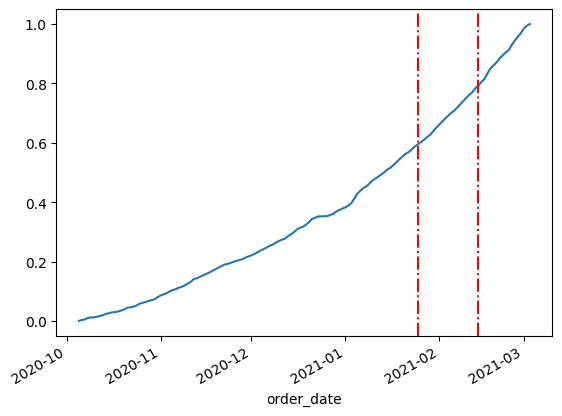

In [55]:
daily_orders = df_feature.groupby('order_date')['order_id'].nunique()
order_cumsum = daily_orders.cumsum() / daily_orders.sum()

train_thr   = order_cumsum[order_cumsum <= 0.6].idxmax()
val_thr     = order_cumsum[order_cumsum <= 0.8].idxmax()

print('Train since', order_cumsum.idxmin())
print('Train until', train_thr)
print('Val until', val_thr)
print('Test until', order_cumsum.idxmax() )

order_cumsum.plot(kind = 'line')
plt.axvline(x = train_thr, color='red', linestyle='-.')
plt.axvline(x = val_thr, color='red', linestyle='-.')

In [58]:
train_df    = df_feature[df_feature.order_date <= train_thr]
val_df      = df_feature[df_feature.order_date.between(train_thr, val_thr, inclusive = 'right')]
test_df     = df_feature[df_feature.order_date > val_thr]

assert train_df.order_date.isin(val_df.order_date).sum() == 0, 'train and val share some date'
assert train_df.order_date.isin(test_df.order_date).sum() == 0, 'train and test share some date'
assert val_df.order_date.isin(test_df.order_date).sum() == 0, 'test and val share some date'

In [ ]:
target = 'outcome'
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
cat_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
exclude_cols = ['days_since_purchase_variant_id', 'days_since_purchase_product_type']

feature_cols = [col for col in df_feature.columns if col not in info_cols + [target]]
numeric_cols = [col for col in feature_cols if col not in cat_cols + binary_cols]